**Before you fork, please support and upvote!**

# Prostate cANcer graDe Assessment (PANDA) Challenge




Versions:

1.First run, didn't work because inference had error

2.First successful run - LB: 0.59

3.Added TTA - LB: 0.63

4.Tried mixup - LB: 0.62

6.Tried label smoothing - LB: 0.67

9.Try larger model(SE-ResNext101) - LB: 0.66

10.Added 5-fold CV training


## Introduction
Prostate cancer is the [most common cancer in males in the United States](https://gis.cdc.gov/Cancer/USCS/DataViz.html) and [most common cancer in men worldwide](https://www.wcrf.org/dietandcancer/cancer-trends/worldwide-cancer-data). 

Diagnosis _and prognosis_ is based on [histology](https://en.wikipedia.org/wiki/Histology) analysis of prostate samples taken via biopsy. The tissue samples are scored by pathologists with the [Gleason grading system](https://en.wikipedia.org/wiki/Gleason_grading_system) ([developed](https://www.ncbi.nlm.nih.gov/pubmed/5948714) by Dr. Donald Gleason in 1966). Cancers with higher Gleason score are more aggressive and have a worse prognosis.

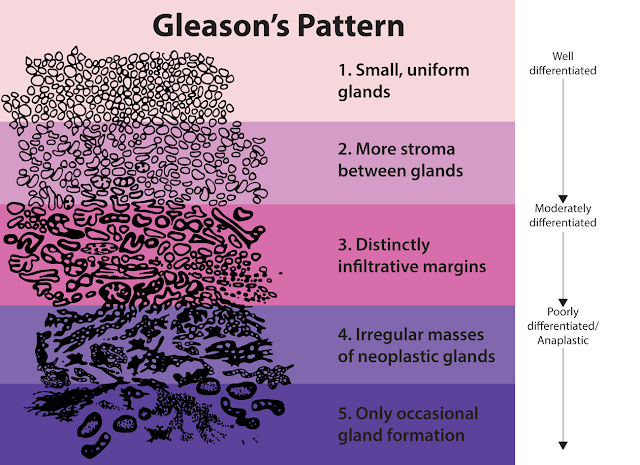

The Gleason score is based on the identificatio of Gleason "patterns" in the biopsy specimen. A primary and secondary grade is assigned, which is based on the dominant, and the next-most frequent patterns, respectively. The final Gleason score is a sum of these two, such as `7 (3+4)`. The individual Gleason grades can technically vary from 1 to 5, but Gleason grades 1 and 2 are discontinued as they do not differ in outcome from grade 3.

In 2014, the International Society of Urological Pathology (ISUP) suggested a new 5-grade system for combining the primary and secondary Gleason grades:

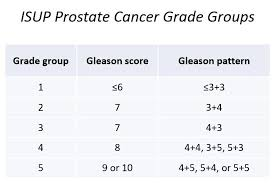

A major problem with the Gleason grading scale is inter-pathologist variability ([here](https://www.ncbi.nlm.nih.gov/pubmed/21146858) and [here](https://www.ncbi.nlm.nih.gov/pubmed/27416104)). This variability of diagnosis could result in unnecessary treatment of missing severe cases. Therefore, deep learning has an opportunity to automate and improve the objectivity of the grading. Such deep learning systems to augment the pathologist's workflow and decrease the overall workload.

Several systems have already been developed. This includes some work by [Google](https://ai.googleblog.com/2018/11/improved-grading-of-prostate-cancer.html), as well as [some work](https://www.thelancet.com/journals/lanonc/article/PIIS1470-2045(19)30739-9/fulltext) from the competition organizers. However, the major difference with this challenge is the use of a multi-center extensive dataset, that is the largest public whole-slide image dataset available. 

Clearly this is an important problem, and I am excited to work this this unique dataset.

## A look at the data

There is a detailed report of the PANDA challenge dataset available [here](https://zenodo.org/record/3715938#.XqPQe2hKhEa).

> Your challenge in this competition is to classify the severity of prostate cancer from microscopy scans of prostate biopsy samples. There are two unusual twists to this problem relative to most competitions:
> 
> Each individual image is quite large. We're excited to see what strategies you come up with for efficiently locating areas of concern to zoom in on.
> 
> The labels are imperfect. This is a challenging area of pathology and even experts in the field with years of experience do not always agree on how to interpret a slide. This will make training models more difficult, but increases the potential medical value of having a strong model to provide consistent ratings. All of the private test set images and most of the public test set images were graded by multiple pathologists, but this was not feasible for the training set. You can find additional details about how consistently the pathologist's labels matched here.


In the train.csv file, the `data_provider` (Karolinska Institute or Radboud University Medical Center), `isup_grade` (the target, only provided in train), and the `gleason_score` (train only) is provided.

Whole-slide images are often digitally saved as multi-level TIFF files. This is the case for the images here: 10616 train images, and ~1000 test images.

Let's analyze the images a little further.

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
import openslide
import os
from PIL import Image
import pandas as pd
import numpy as np

# Quick and dirty EDA:

Let's check out our csv file and the labels:

In [ ]:
train_df = pd.read_csv('../input/prostate-cancer-grade-assessment/train.csv')

In [ ]:
train_df.head(10)

In [ ]:
len_df = len(train_df)
print(f"There are {len_df} train images")

In [ ]:
train_df['isup_grade'].hist(figsize = (10, 5))

The labels are somewhat imbalanced, with no cancer and the least aggressive version, being the most common labels.

Let's look at the individual Gleason pattern scores:

In [ ]:
train_df[['primary Gleason', 'secondary Gleason']] = train_df.gleason_score.str.split('+',expand=True)

In [ ]:
train_df[['primary Gleason', 'secondary Gleason']]

In [ ]:
train_df['primary Gleason'].hist(figsize = (10, 5))

In [ ]:
train_df['secondary Gleason'].hist(figsize = (10, 5))

Here, we see that the Gleason pattern 3 is the most common.

Now let's check some example images. We can use [OpenSlide](https://openslide.org/) as an interface to open and display these whole-slide images:

In [ ]:
ex_img_path = '../input/prostate-cancer-grade-assessment/train_images/'+train_df['image_id'][np.random.choice(len(train_df))]+'.tiff'
example_image = openslide.OpenSlide(ex_img_path)

OpenSlide provides a lot of information about the file properties:

In [ ]:
example_image.properties

Here we can see that the images have 3 levels, and the sizes of those levels are shown. The first level is the full-resolution image, and the subsequent ones are downsampled versions. We will work with level 3, the most downsampled version.

In [ ]:
img = example_image.read_region(location=(0,0),level=2,size=(example_image.level_dimensions[2][0],example_image.level_dimensions[2][1]))
print(img.size)
img

You can use the `read_region` function to read patches of the image without loading the whole image into memory.

These images are quite large, even though they are downsampled. We will use a 512x512-resized version of the dataset that I generated [here](https://www.kaggle.com/tanlikesmath/panda-challenge-512x512-resized-dataset/). If you want a 256x256 version, please see [here](https://www.kaggle.com/tanlikesmath/panda-challenge-256x256-resized-dataset/). Please upvote these kernels if you find them helpful. Note that this kernel is using the output of these other kernels. This is a great alternative to creating datasets in my opinion, and it allows you to save dataset storage space ;)

Now that we understand the problem and the dataset, we can create a simple baseline, which, as we will see, performs pretty well.

## fastai2 training baseline

Note that no internet connection is allowed.

Let's install [fastai2](https://github.com/fastai/fastai2) and [pretrainedmodels](https://github.com/Cadene/pretrained-models.pytorch) and its dependencies:

In [ ]:
!pip install /kaggle/input/fastai2-wheels/fastscript-0.1.4-py3-none-any.whl > /dev/null
!pip install /kaggle/input/fastai2-wheels/kornia-0.2.0-py2.py3-none-any.whl > /dev/null
!pip install /kaggle/input/fastai2-wheels/nbdev-0.2.12-py3-none-any.whl > /dev/null
!pip install /kaggle/input/fastai2-wheels/fastprogress-0.2.3-py3-none-any.whl > /dev/null
!pip install /kaggle/input/fastai2-wheels/fastcore-0.1.16-py3-none-any.whl > /dev/null
!pip install /kaggle/input/fastai2-wheels/fastai2-0.0.16-py3-none-any.whl > /dev/null
!pip install ../input/pretrainedmodels/pretrainedmodels-0.7.4/pretrainedmodels-0.7.4/ > /dev/null

In [ ]:
from fastai2.vision.all import *
import pretrainedmodels

Let's move the SE-ResNext model weights to the appropriate location for PyTorch to find.

In [ ]:
# Making pretrained weights work without needing to find the default filename
if not os.path.exists('/root/.cache/torch/checkpoints/'):
        os.makedirs('/root/.cache/torch/checkpoints/')
!cp '../input/pytorch-se-resnext/se_resnext50_32x4d-a260b3a4.pth' '/root/.cache/torch/checkpoints/se_resnext50_32x4d-a260b3a4.pth'

Always seed everything! :)

In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

SEED = 999
seed_everything(SEED)

In fastai2, you define a "template" for how to process your data. This is known as a DataBlock. Here we define our DataBlock to use the image files defined in the column `image_id`, and use the labels defined in the column `isup_grade`. The images are resized (meaningless for now since already at 512), and augmentation is performed on the GPU.

In [ ]:
train_df['image_id'] = '../input/panda-challenge-512x512-resized-dataset/' + train_df['image_id']

In [ ]:
panda_block = DataBlock(blocks=(ImageBlock, CategoryBlock),
                        splitter=RandomSplitter(),
                        get_x=ColReader('image_id',suff='.jpeg'),
                        get_y=ColReader('isup_grade'),
                        item_tfms=Resize(512),
                        batch_tfms=aug_transforms()
                       )

With our Data Block defined, we can create train and valid DataLoaders with all the information in the `train_df`.

In [ ]:
dls = panda_block.dataloaders(train_df,bs=16)

Let's view an example batch. If this does not succeed and there is an error in your code, you can use `panda_block.summary(train_df)` to print out the entire pipeline and debug your code.

In [ ]:
dls.show_batch()

## Creating a Learner

OK let's define our model and create a `Learner` from the model and the dataloaders. We also pass in our competition metric, which is Quadratic Cohen's Kappa. This is a good metric when studying inter-observer variability.

In [ ]:
m = pretrainedmodels.se_resnext50_32x4d(pretrained='imagenet')
children = list(m.children())
head = nn.Sequential(nn.AdaptiveAvgPool2d(1), Flatten(), 
                                  nn.Linear(children[-1].in_features,200))
model = nn.Sequential(nn.Sequential(*children[:-2]), head)

In [ ]:
learn = Learner(dls,model,splitter=default_split,loss_func = LabelSmoothingCrossEntropy(), opt_func=ranger, metrics=[accuracy,CohenKappa(weights='quadratic')])

We have used the Label Smoothing Cross Entropy function, which is a regularization technique that will make our model more robust and generalize better.

We can use the learning rate finder in order to find the best learning rate. We freeze the model for now.

In [ ]:
learn.freeze()
learn.lr_find()

From this, we can determine that maybe 3e-2 is a good learning rate. We could also do this once we unfreeze our model (as shown below).

## 5-fold CV

Let's train a 5-fold CV ensemble. First, I write a function to train a model for a given fold.

In [ ]:
def train_fold(fold,val_idx):
    panda_block = DataBlock(blocks=(ImageBlock, CategoryBlock),
                        splitter=IndexSplitter(val_idx),
                        get_x=ColReader('image_id',suff='.jpeg'),
                        get_y=ColReader('isup_grade'),
                        item_tfms=Resize(512),
                        batch_tfms=aug_transforms()
                       )
    dls = panda_block.dataloaders(train_df,bs=16)
    learn = Learner(dls,model,splitter=default_split,loss_func = LabelSmoothingCrossEntropy(), metrics=[CohenKappa(weights='quadratic')]).to_fp16()
    learn.freeze()
    learn.fit_flat_cos(5,3e-2,cbs=[SaveModelCallback(monitor='cohen_kappa_score')],pct_start=0.5)
    learn.save(f'stage-1-512-fold{fold}')
    learn = learn.load(f'stage-1-512-fold{fold}')
    learn.unfreeze()
    learn.fit_flat_cos(5,slice(1e-6,1e-3),cbs=[SaveModelCallback(monitor='cohen_kappa_score')],pct_start=0.5)
    learn.save(f'stage-2-512-fold{fold}')
    learn.export(f'fold{fold}.pkl')
    return learn.validate()[1]

Let's set up a CV:

In [ ]:
from sklearn.model_selection import StratifiedKFold
splits = StratifiedKFold(n_splits=5, random_state=SEED, shuffle=True)
scores = []
for fold, (trn_idx, valid_idx) in enumerate(splits.split(train_df,train_df.isup_grade)):
    score = train_fold(fold, valid_idx)
    scores.append(score)

In [ ]:
print(f'5-fold CV score: {np.mean(scores)}')

# Inference

This is a synchronous code-only competition. This means we submit inference kernels that run on the test set and generate predictions. In this case, the training kernel is also the inference kernel, but you could also separate them.

This competition presents a unique challenge in that there is no public test data available to run on. The test data is just made available during submission of the kernel. So be careful (I messed up 4 times before getting this to work) and make sure your kernel at least works on the train set and then use an if-statement (see below) to perform inference only when the test images are available.

In my kernel, I resize all the test images and save them, then perform inference on that.

In [ ]:
os.mkdir('resized-test')

In [ ]:
test_df = pd.read_csv('../input/prostate-cancer-grade-assessment/test.csv')

In [ ]:
test_df.head(10)

In [ ]:
sample_submission = pd.read_csv('../input/prostate-cancer-grade-assessment/sample_submission.csv')

Here we define a function to resize the test images.

In [ ]:
def resize_test_images():
    for i in test_df['image_id']:
        openslide_image = openslide.OpenSlide(str('../input/prostate-cancer-grade-assessment/test_images/'+i+'.tiff'))
        img = openslide_image.read_region(location=(0,0),level=2,size=(openslide_image.level_dimensions[2][0],openslide_image.level_dimensions[2][1]))
        Image.fromarray(np.array(img.resize((512,512)))[:,:,:3]).save('./resized-test/'+i+'.jpeg')
    test_df['image_id'] = './resized-test/' + test_df['image_id']

Here we define an inference function that generates a test dataloader, then runs the model and gets the predictions. We use test-time augmentation (TTA), which is implemented in the fastai2 library.

In [ ]:
def inference_fn(fold):
    test_dl = dls.test_dl(test_df)
    learn.load(f'stage-2-512-fold{fold}')
    preds, _ = learn.tta(dl=test_dl,beta=0)
    print(preds)
    test_preds = preds.argmax(-1)
    return test_preds

We now write a function to perform inference for all the folds.

In [ ]:
def inference_5folds():
    resize_test_images()
    predictions = torch.from_numpy(np.zeros((len(test_df))))
    for i in range(5):
        test_preds = inference_fn(i)
        predictions = predictions + test_preds
    
    predictions = torch.round(predictions/5)
    sample_submission.isup_grade = predictions
    sample_submission['isup_grade'] = sample_submission['isup_grade'].astype(int)

This if-statement is necessary for proper submission of the code.

In [ ]:
if os.path.exists('../input/prostate-cancer-grade-assessment/test_images'):
    print('inference!')
    inference_5folds()

When we submit the kernel, the above code will run and the submission dataframe will be populated with our predictions. We just save our submission CSV:

In [ ]:
sample_submission.to_csv('submission.csv', index=False)

In [ ]:
sample_submission.head(10)

Now, **WE ARE DONE**!

If you enjoyed this kernel, please give it an upvote. Also check out the following resources below:

Datasets used in this kernel:
- [512x512 resized dataset](https://www.kaggle.com/tanlikesmath/panda-challenge-512x512-resized-dataset) 

- [Cadene's pretrainedmodels](https://www.kaggle.com/rishabhiitbhu/pretrainedmodels) 

- [PyTorch SE-ResNext weights](https://www.kaggle.com/yasufuminakama/pytorch-se-resnext)

- [fastai2 wheels](https://www.kaggle.com/vijayabhaskar96/fastai2-wheels)

Other useful kernels/datasets I have:

- [256x256 resized dataset](https://www.kaggle.com/tanlikesmath/panda-challenge-256x256-resized-dataset)
- [precursor kernel (fastai2 training baseline)](https://www.kaggle.com/tanlikesmath/fastai2-training-baseline)

# References:

Wikipedia - Gleason grading system:
https://en.wikipedia.org/wiki/Gleason_grading_system

Pathology Outlines - Grading (Gleason):
http://www.pathologyoutlines.com/topic/prostategrading.html

# Fin